In [3]:
!pip install transformers tokenizers seqeval evaluate datasets==3.6.0 -q > /dev/null 2>&1

# Carga de datos

Si posee el archivo .conll, puede utilizar el codigo comentado,
Caso contrario se preparó un dataset listo para entrenar

In [ ]:
"""
#Cargar el .conll
from google.colab import drive
drive.mount('/content/drive')
file_path = "/content/drive/MyDrive/YARUQUI/data/traindata.conll"


from datasets import Dataset, DatasetDict, Sequence, ClassLabel, Value, load_dataset
import random

# Configuración de semilla y porcentajes
seed = 42  # Semilla para reproducibilidad
test_size = 0.15  # 15% para prueba
validation_size = 0.15  # 15% para validación

# Función para leer el archivo .conll
def read_conll_file(file_path):
    sentences = []
    current_tokens = []
    current_labels = []

    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line:
                if current_tokens:
                    sentences.append({'tokens': current_tokens, 'ner_tags': current_labels})
                    current_tokens = []
                    current_labels = []
                continue

            parts = line.split()
            token = parts[0]
            label = parts[-1]

            current_tokens.append(token)
            current_labels.append(label2id[label])

    if current_tokens:
        sentences.append({'tokens': current_tokens, 'ner_tags': current_labels})

    return sentences
"""

In [2]:
"""
# Cargar y procesar datos
data = read_conll_file(file_path)

# Mezclar los datos con semilla
random.seed(seed)
random.shuffle(data)

# Calcular tamaños de los splits
n_total = len(data)
n_test = int(n_total * test_size)
n_val = int(n_total * validation_size)
n_train = n_total - n_test - n_val

# Dividir los datos
train_data = data[:n_train]
val_data = data[n_train:n_train + n_val]
test_data = data[n_train + n_val:]

# Crear DatasetDict
class_label = ClassLabel(names=label_names)
raw_datasets = DatasetDict({
    'train': Dataset.from_list(train_data).cast_column('ner_tags', Sequence(class_label)),
    'validation': Dataset.from_list(val_data).cast_column('ner_tags', Sequence(class_label)),
    'test': Dataset.from_list(test_data).cast_column('ner_tags', Sequence(class_label))
})

# Verificar resultados
print("Tamaños de los datasets:")
print(f"Entrenamiento: {len(raw_datasets['train'])}")
print(f"Validación: {len(raw_datasets['validation'])}")
print(f"Prueba: {len(raw_datasets['test'])}")
"""

#Cargar los datos ya seteados desde el repo (En caso de no poseer el .conll)
from datasets import load_dataset
raw_datasets = load_dataset("aatituanav/bert-spanish-cased-finetuned-ner-6ent")
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 77
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 16
    })
    test: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 16
    })
})

# ENTRENAMIENTO DEL MODELO

In [ ]:
label_names = [
    'O',
    'B-PERSONA', 'I-PERSONA',
    'B-CARGO', 'I-CARGO',
    'B-DINERO', 'I-DINERO',
    'B-FECHA', 'I-FECHA',
    'B-PROYECTO', 'I-PROYECTO',
    'B-REGLAMENTO', 'I-REGLAMENTO'
]

In [ ]:
id2label = {i: label for i, label in enumerate(label_names)}
label2id = {v: k for k, v in id2label.items()}

In [ ]:
from transformers import AutoTokenizer

model_checkpoint = "dccuchile/distilbert-base-spanish-uncased-finetuned-ner"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/397 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
def align_labels_with_tokens(labels, word_ids):
    #"Permte alinear la matriz ner_tags con las palabras ya tokenizadas"
    #Ya que actualmente la matriz neg_tags (labels) estan mapeadas a los inputs o textos, no a los textos tokenizados
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word:
            current_word = word_id
            label = -100 if word_id is None else labels[word_id]
            new_labels.append(label)
        elif word_id is None:
            new_labels.append(-100)
        else:
            label = labels[word_id]
            if label % 2 == 1:
                label += 1
            new_labels.append(label)

    return new_labels

In [ ]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"], truncation=True, is_split_into_words=True, max_length=512
    )
    all_labels = examples["ner_tags"]
    new_labels = []
    for i, labels in enumerate(all_labels):
        word_ids = tokenized_inputs.word_ids(i)
        new_labels.append(align_labels_with_tokens(labels, word_ids))

    tokenized_inputs["labels"] = new_labels
    return tokenized_inputs

In [ ]:
tokenized_datasets = raw_datasets.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=raw_datasets["train"].column_names,
)

Map:   0%|          | 0/77 [00:00<?, ? examples/s]

Map:   0%|          | 0/16 [00:00<?, ? examples/s]

Map:   0%|          | 0/16 [00:00<?, ? examples/s]

In [ ]:
from transformers import DataCollatorForTokenClassification
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

In [ ]:
import evaluate
metric = evaluate.load("seqeval")

In [ ]:
import numpy as np
def compute_metrics(eval_preds):
    '''
      Calcula las métricas de evaluación para NER.
      Para ello utiliza las predicciones y labels reales.
      Retorna un diccionario con las métricas.
    '''
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)

    # Elimino los tokens especiales -100
    true_labels = [[label_names[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [label_names[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    all_metrics = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": all_metrics["overall_precision"],
        "recall": all_metrics["overall_recall"],
        "f1": all_metrics["overall_f1"],
        "accuracy": all_metrics["overall_accuracy"],
    }

In [ ]:
from transformers import AutoModelForTokenClassification

model_for_training = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)
print(f'Clases del modelo {model_for_training.config.num_labels}')

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at dccuchile/distilbert-base-spanish-uncased-finetuned-ner and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([9, 768]) in the checkpoint and torch.Size([13, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([9]) in the checkpoint and torch.Size([13]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Clases del modelo 13


In [ ]:
from transformers import TrainingArguments

args = TrainingArguments(
    "bert-spanish-cased-finetuned-ner-6ent",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=2e-5,
    num_train_epochs=15,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
)

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model_for_training,
    args=args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    processing_class=tokenizer,
)
trainer.train()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: carloswringo (carloswringo-universidad-central-del-ecuador) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,2.073300,1.482587,0.037037,0.025641,0.030303,0.602581
2,1.230300,0.875981,0.346154,0.307692,0.325792,0.812903
3,0.727800,0.474140,0.678261,0.666667,0.672414,0.890968
4,0.424100,0.279998,0.889831,0.897436,0.893617,0.927742
5,0.270900,0.184940,0.932203,0.940171,0.936170,0.958710
6,0.188100,0.135469,0.923729,0.931624,0.927660,0.975484
7,0.139700,0.106358,0.932203,0.940171,0.936170,0.981290
8,0.104300,0.087902,0.940678,0.948718,0.944681,0.989677
9,0.087100,0.077347,0.940678,0.948718,0.944681,0.990323
10,0.076100,0.072032,0.940678,0.948718,0.944681,0.991613


/usr/local/lib/python3.12/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TrainOutput(global_step=150, training_loss=0.37463412642478944, metrics={'train_runtime': 375.9336, 'train_samples_per_second': 3.072, 'train_steps_per_second': 0.399, 'total_flos': 46852791313710.0, 'train_loss': 0.37463412642478944, 'epoch': 15.0})

In [ ]:
"""
#Publicar modelo en Hugging Face
from huggingface_hub import notebook_login
notebook_login()

trainer.push_to_hub("aatituanav/bert-spanish-cased-finetuned-ner-6ent")
raw_datasets.push_to_hub("aatituanav/bert-spanish-cased-finetuned-ner-6ent")
"""

=== EVALUACIÓN DEL MODELO ===

--- Evaluación en conjunto de PRUEBA ---


Pérdida en prueba: 0.0658
Precisión: 0.9318
Recall: 0.9462
F1-score: 0.9389
Exactitud: 0.9881

--- REPORTE DETALLADO POR CLASE (conjunto de prueba) ---
              precision    recall  f1-score   support

       CARGO       0.95      0.95      0.95        21
      DINERO       1.00      1.00      1.00        24
       FECHA       0.89      0.93      0.91        27
     PERSONA       1.00      1.00      1.00        20
    PROYECTO       0.76      0.81      0.79        16
  REGLAMENTO       0.95      0.95      0.95        22

   micro avg       0.93      0.95      0.94       130
   macro avg       0.93      0.94      0.93       130
weighted avg       0.93      0.95      0.94       130


--- MATRIZ DE CONFUSIÓN VISUAL ---


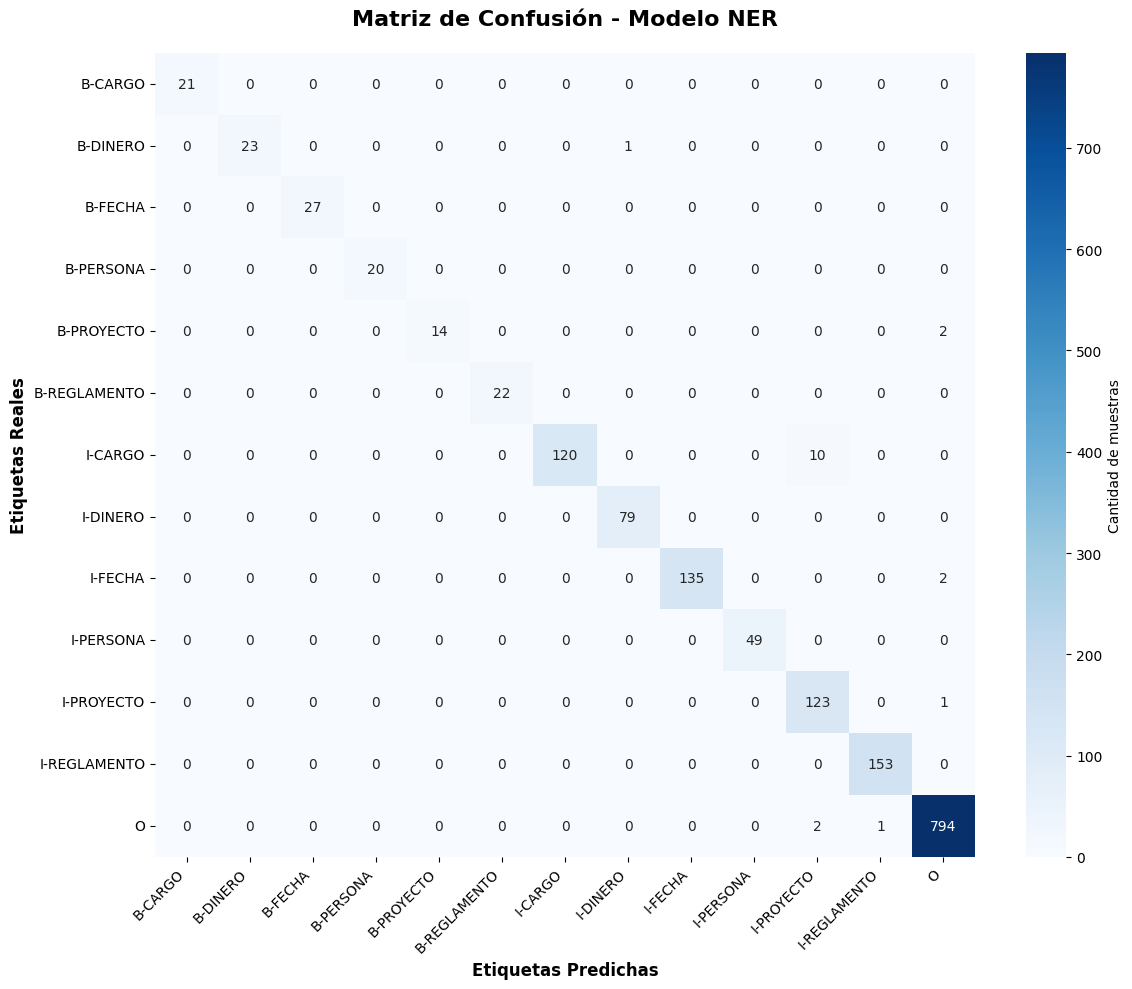


--- MATRIZ DE CONFUSIÓN NORMALIZADA ---


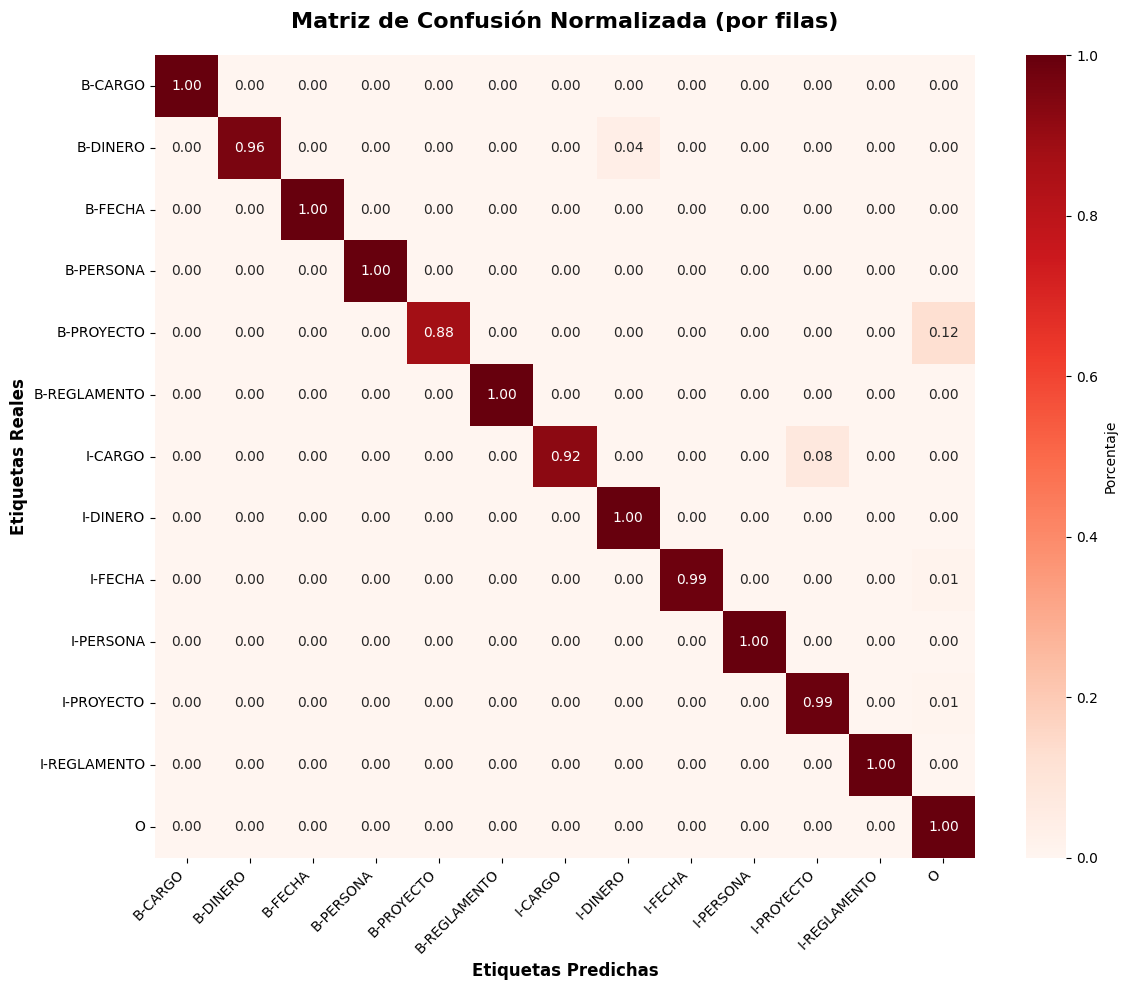

In [ ]:
from seqeval.metrics import classification_report, f1_score, precision_score, recall_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix


# Función para evaluar el modelo en todos los conjuntos
def evaluate_model(trainer, tokenized_datasets, label_names):
    print("=== EVALUACIÓN DEL MODELO ===")

    # Evaluar en conjunto de prueba
    print("\n--- Evaluación en conjunto de PRUEBA ---")
    test_metrics = trainer.evaluate(tokenized_datasets["test"])
    print(f"Pérdida en prueba: {test_metrics['eval_loss']:.4f}")
    print(f"Precisión: {test_metrics['eval_precision']:.4f}")
    print(f"Recall: {test_metrics['eval_recall']:.4f}")
    print(f"F1-score: {test_metrics['eval_f1']:.4f}")
    print(f"Exactitud: {test_metrics['eval_accuracy']:.4f}")

    # Generar reporte detallado por clase en el conjunto de prueba
    print("\n--- REPORTE DETALLADO POR CLASE (conjunto de prueba) ---")
    predictions, labels, _ = trainer.predict(tokenized_datasets["test"])
    predictions = np.argmax(predictions, axis=-1)

    # Eliminar tokens especiales y convertir a etiquetas
    true_predictions = [
        [label_names[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_names[l] for l in label if l != -100]
        for label in labels
    ]

    # Generar reporte de clasificación
    report = classification_report(true_labels, true_predictions)
    print(report)

    # Calcular matriz de confusión
    print("\n--- MATRIZ DE CONFUSIÓN VISUAL ---")
    flat_true_labels = [label for sublist in true_labels for label in sublist]
    flat_true_predictions = [label for sublist in true_predictions for label in sublist]
    all_labels = sorted(list(set(flat_true_labels + flat_true_predictions)))

    cm = confusion_matrix(flat_true_labels, flat_true_predictions, labels=all_labels)

    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=all_labels, yticklabels=all_labels,
                cbar_kws={'label': 'Cantidad de muestras'})

    # Configurar etiquetas
    plt.title('Matriz de Confusión - Modelo NER', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Etiquetas Predichas', fontsize=12, fontweight='bold')
    plt.ylabel('Etiquetas Reales', fontsize=12, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig('matriz_confusion_ner.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("\n--- MATRIZ DE CONFUSIÓN NORMALIZADA ---")
    # Normalizar por filas (por etiqueta real)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_normalized = np.nan_to_num(cm_normalized)  # Evitar division por cero
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Reds',
                xticklabels=all_labels, yticklabels=all_labels,
                cbar_kws={'label': 'Porcentaje'})

    plt.title('Matriz de Confusión Normalizada (por filas)', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Etiquetas Predichas', fontsize=12, fontweight='bold')
    plt.ylabel('Etiquetas Reales', fontsize=12, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig('matriz_confusion_normalizada.png', dpi=300, bbox_inches='tight')
    plt.show()

    return test_metrics, report

test_metrics, report = evaluate_model(trainer, tokenized_datasets, label_names)